# Notebook 2 - Exploratory Data Analysis (EDA)

The aim of this research is to leverage **geophysical** and **geological** data to predict **gold occurrences** in the **Tapajós Mineral Province**. By identifying prospective areas more accurately, we can potentially **discover new deposits** and **optimize** exploration efforts, reducing both **costs** and **time** by focusing on **high-precision** targets.

In this notebook, we focus on **Exploratory Data Analysis (EDA)**. Our main goals are:
- **Understand** the distributions of the geophysical layers (e.g., Bouguer Anomaly, Radiometric channels, Magnetometry).
- **Inspect** the spatial coverage and any missing data or outliers.
- **Assess** class imbalance by analyzing the occurrence vs. non-occurrence pixels.
- **Evaluate** correlations among features and with the gold occurrences.
- **Explore** lithology frequencies and their relationship with gold presence.

By performing these analyses, we gain **insights** into which variables may be most predictive, where potential **transformations** (log, robust scaling, etc.) are needed, and how **imbalanced** the data is. The results here will guide our **feature engineering** decisions and **modeling approaches** in subsequent notebooks.

Author: João Paulo Alves - joao dot guilherme dot alves @ usp dot br

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install geopandas rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.1 MB/s eta 0:00:00


In [3]:
# Importing libs
import os
import numpy as np
import geopandas as gpd
import rasterio
import pandas as pd
from rasterio.features import rasterize
from scipy.stats import pointbiserialr

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.font_manager import FontProperties

In [4]:
# Data frame for mosaic plot
df_info = pd.DataFrame([
    {
        "filename": "BouguerAnom.tif",
        "display_name": "Bouguer Anom.",
        "units": "mGal",
        "plot_order": 1
    },
    {
        "filename": "TernaryComp.tif",
        "display_name": "Ternary Comp.",
        "units": "",
        "plot_order": 10
    },
    {
        "filename": "TotalCount.tif",
        "display_name": "Total Count",
        "units": "cps",
        "plot_order": 6
    },
    {
        "filename": "Elev.tif",
        "display_name": "Elev.",
        "units": "m",
        "plot_order": 2
    },
    {
        "filename": "PotEq.tif",
        "display_name": "Pot. Eq.",
        "units": "%",
        "plot_order": 7
    },
    {
        "filename": "ThEq.tif",
        "display_name": "Th. Eq.",
        "units": "ppm",
        "plot_order": 8
    },
    {
        "filename": "UEq.tif",
        "display_name": "U. Eq.",
        "units": "ppm",
        "plot_order": 9
    },
    {
        "filename": "TotGrad.tif",
        "display_name": "Tot. Grad.",
        "units": "nT",
        "plot_order": 5
    },
    {
        "filename": "Lithology.tif",
        "display_name": "Lithology",
        "units": "",
        "plot_order": 12
    },
    {
        "filename": "Magnetom.tif",
        "display_name": "Magnetom.",
        "units": "nT",
        "plot_order": 3
    },
    {
        "filename": "1VD.tif",
        "display_name": "1VD",
        "units": "nT/m",
        "plot_order": 4
    },
    {
        "filename": "ThKRatio.tif",
        "display_name": "Th/K Ratio",
        "units": "ratio",
        "plot_order": 11
    },
])

In [5]:
# Reading data
RASTER_DIR  = "/content/drive/MyDrive/OrePredictionProject/data/raster_data"
OCC_GPKG  = "/content/drive/MyDrive/OrePredictionProject/data/vector_data/GoldDeposits.gpkg"
FIGS_DIR =  "/content/drive/MyDrive/OrePredictionProject/figures"

In [6]:
# List .tif files
geotiffs = [os.path.join(RASTER_DIR, x) for x in os.listdir(RASTER_DIR) if x.endswith('.tif')]
print("Point filename:", OCC_GPKG)
print("GeoTIFF files:", geotiffs)

Point filename: /content/drive/MyDrive/OrePredictionProject/data/vector_data/GoldDeposits.gpkg
GeoTIFF files: ['/content/drive/MyDrive/OrePredictionProject/data/raster_data/UEq.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/TotGrad.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/TotalCount.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/ThKRatio.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/ThEq.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/TernaryComp.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/PotEq.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/Magnetom.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/Lithology.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/Elev.tif', '/content/drive/MyDrive/OrePredictionProject/data/raster_data/BouguerAnom.tif', '/content/drive/MyDrive/OrePredictionProject/data/

In [7]:
# Read occurrences
gold_df = gpd.read_file(OCC_GPKG)
print("Gold occurrences (first 5 rows):")
print(gold_df.head())
print("\n Number of points:")
print(len(gold_df))

Gold occurrences (first 5 rows):
   fid_2                           geometry
0      1    MULTIPOINT ((-58.0171 -5.7004))
1      1  MULTIPOINT ((-57.38995 -6.16422))
2      1  MULTIPOINT ((-57.34073 -6.07066))
3      1  MULTIPOINT ((-57.00997 -6.88393))
4      1  MULTIPOINT ((-57.95612 -5.43677))

 Number of points:
570


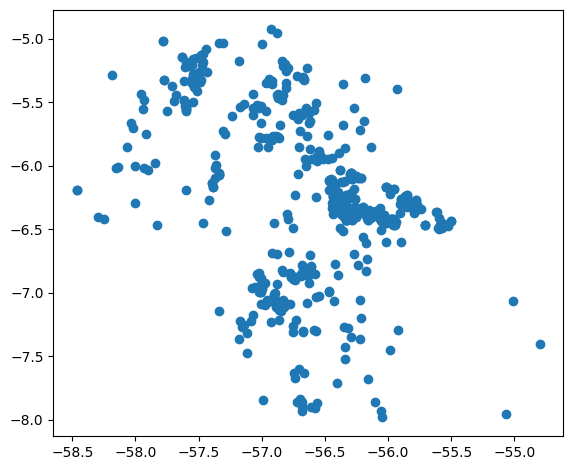

In [8]:
# Gold occurrences plot (vector)
fig, ax = plt.subplots()
gold_df.plot(ax=ax)

plt.tight_layout()
plt.show()

In [9]:
data_list = []
layer_names = []
transform = None
region_bounds = None

for fn in geotiffs:
    with rasterio.open(fn, 'r') as src:
        arr = src.read(1).astype(np.float32)
        # Convert NoData to NaN
        nodata_mask = (arr == src.nodata)
        arr[nodata_mask] = np.nan
        data_list.append(arr)

        base_name = os.path.basename(fn).replace('.tif','')
        layer_names.append(base_name)

        if transform is None:
            transform = src.transform
            region_bounds = src.bounds

data_stack = np.stack(data_list, axis=0)
print("Data shape (layers, rows, cols):", data_stack.shape)

Data shape (layers, rows, cols): (12, 693, 807)


In [10]:
df_loaded = pd.DataFrame({
    "names": layer_names,
    "index": range(len(layer_names))
})

In [11]:
# Ensure df_info has a 'names' column matching the raster's base_name
df_info["names"] = df_info["filename"].str.replace(".tif", "", regex=False)

In [12]:
df_merged = pd.merge(df_loaded, df_info, on="names", how="left")

In [13]:
df_merged_sorted = df_merged.sort_values("plot_order")

In [14]:
sorted_indices = df_merged_sorted["index"].tolist()
data_sorted = data_stack[sorted_indices, :, :]  # shape: (layers, rows, cols)

In [15]:
sorted_layer_names = df_merged_sorted["display_name"].tolist()
sorted_layer_units = df_merged_sorted["units"].tolist()

In [16]:
print("\nSorted DataFrame:\n", df_merged_sorted)


Sorted DataFrame:
           names  index         filename   display_name  units  plot_order
10  BouguerAnom     10  BouguerAnom.tif  Bouguer Anom.   mGal           1
9          Elev      9         Elev.tif          Elev.      m           2
7      Magnetom      7     Magnetom.tif      Magnetom.     nT           3
11          1VD     11          1VD.tif            1VD   nT/m           4
1       TotGrad      1      TotGrad.tif     Tot. Grad.     nT           5
2    TotalCount      2   TotalCount.tif    Total Count    cps           6
6         PotEq      6        PotEq.tif       Pot. Eq.      %           7
4          ThEq      4         ThEq.tif        Th. Eq.    ppm           8
0           UEq      0          UEq.tif         U. Eq.    ppm           9
5   TernaryComp      5  TernaryComp.tif  Ternary Comp.                 10
3      ThKRatio      3     ThKRatio.tif     Th/K Ratio  ratio          11
8     Lithology      8    Lithology.tif      Lithology                 12


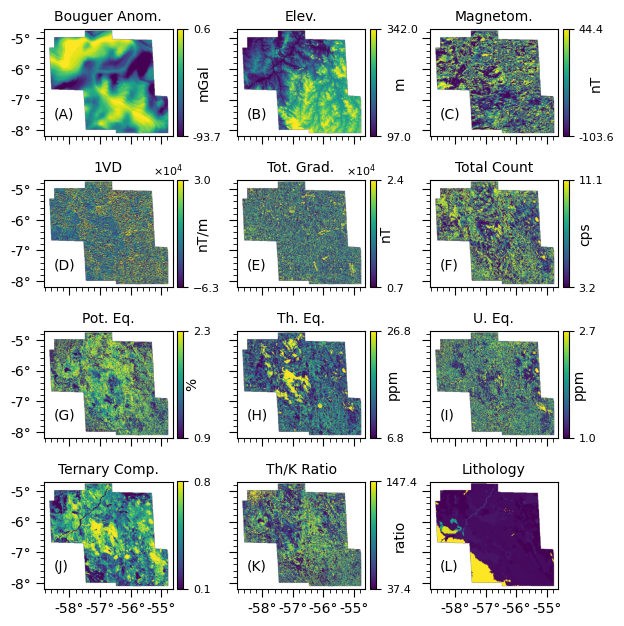

In [17]:
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)', '(J)', '(K)', '(L)']

rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(7, 12), sharex=True, sharey=True)
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    if i < data_sorted.shape[0]:
        row_idx = i // cols
        col_idx = i % cols

        row_info   = df_merged_sorted.iloc[i]
        disp_name  = row_info["display_name"]
        units      = row_info["units"]
        layer_data = data_sorted[i]

        low_val  = np.nanpercentile(layer_data, 5)
        high_val = np.nanpercentile(layer_data, 95)

        im = ax.imshow(
            layer_data,
            vmin=low_val, vmax=high_val,
            extent=[region_bounds.left, region_bounds.right,
                    region_bounds.bottom, region_bounds.top],
            cmap='viridis', origin='upper'
        )

        # Subplot Title & Label
        ax.set_title(f"{disp_name}", x=0.5, y=1, fontsize=10)


        ax.text(
            x=-58.5,
            y=-7.6,
            s=labels[i],
            fontsize=10
        )

        ax.set_xlabel("")
        ax.set_ylabel("")

        # Minor tick locators
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(which='minor', direction='out', size=3)
        ax.tick_params(which='major', direction='out', size=6)

        x_min, x_max = ax.get_xlim()
        x_ticks = np.arange(int(x_min), int(x_max) + 1, 1)
        ax.xaxis.set_major_locator(FixedLocator(x_ticks))
        ax.xaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in x_ticks]))

        y_min, y_max = ax.get_ylim()
        y_ticks = np.arange(int(y_min), int(y_max) + 1, 1)
        ax.yaxis.set_major_locator(FixedLocator(y_ticks))
        ax.yaxis.set_major_formatter(FixedFormatter([f"{tick}\u00B0" for tick in y_ticks]))

        class OneDecimalScalarFormatter(ScalarFormatter):
            def _set_format(self):
                self.format = "%.1f"

        # Colorbar
        cbar = fig.colorbar(im, ax=ax, shrink=0.228, aspect=18, pad=0.03)

        if disp_name == "Lithology":
            # Hide the lithology colorbar
            cbar.ax.set_visible(False)
        else:
            # Set normal ticks/labels for numeric layers
            cbar.set_ticks([low_val, high_val])
            cbar.set_label(units, rotation='vertical', labelpad=-18, fontsize=10)
            cbar.ax.tick_params(labelsize=8)
            cbar.ax.yaxis.get_offset_text().set_fontsize(8)

            # Use scientific notation for large values
            if abs(low_val) > 1000 or abs(high_val) > 1000:
                formatter = OneDecimalScalarFormatter(useMathText=True)
                formatter.set_scientific(True)
                formatter.set_powerlimits((0, 0))  # always show ×10^n
                cbar.ax.yaxis.set_major_formatter(formatter)
            else:
                cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    else:
        ax.axis('off')

plt.subplots_adjust(hspace=-0.68, wspace=0.23)
plt.savefig(f"{FIGS_DIR}/fig2.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

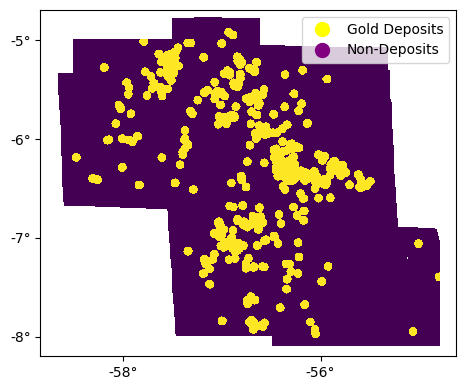

In [18]:
buffer_distance = 0.045
geom_buffered = (geom.buffer(buffer_distance) for geom in gold_df.geometry)
shapes = ((geom, 1) for geom in geom_buffered)

labels_raster = rasterize(
    shapes=shapes,
    out_shape=data_sorted[0].shape,
    fill=0,
    transform=transform
).astype(np.float32)

nan_mask_any = np.any(np.isnan(data_sorted), axis=0)
labels_raster[nan_mask_any] = np.nan

from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(5,4))
img = ax.imshow(labels_raster,
                extent=[region_bounds.left, region_bounds.right,
                        region_bounds.bottom, region_bounds.top],
                cmap='viridis',
                interpolation='none'
               )

ax.xaxis.set_major_locator(MaxNLocator(5))

x_min, x_max = ax.get_xlim()
x_ticks = np.arange(int(x_min), int(x_max) + 1, 2)
ax.xaxis.set_major_locator(FixedLocator(x_ticks))
ax.xaxis.set_major_formatter(FixedFormatter([f"{int(tick)}\u00B0" for tick in x_ticks]))

y_min, y_max = ax.get_ylim()
y_ticks = np.arange(int(y_min), int(y_max) + 1, 1)
ax.yaxis.set_major_locator(FixedLocator(y_ticks))
ax.yaxis.set_major_formatter(FixedFormatter([f"{tick}\u00B0" for tick in y_ticks]))

presence_marker = Line2D([0], [0], marker='o', color='yellow',
                         label='Gold Deposits', markersize=10,
                         markerfacecolor='yellow', linestyle='None')
absence_marker = Line2D([0], [0], marker='o', color='purple',
                        label='Non-Deposits', markersize=10,
                        markerfacecolor='purple', linestyle='None')

ax.legend(handles=[presence_marker, absence_marker], loc='upper right')

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig3.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

We used a ~5000 m buffer to increase the number of occurences pixels and make the dataset less imbalanced.

In [19]:
n_layers, height, width = data_sorted.shape
X_flat = data_sorted.reshape((n_layers, -1)).T
y_flat = labels_raster.flatten()

valid_mask = ~np.isnan(y_flat)
for i in range(n_layers):
    valid_mask &= ~np.isnan(X_flat[:, i])

X_valid = X_flat[valid_mask]
y_valid = y_flat[valid_mask]

print("Number of valid pixels:", len(X_valid))
print("Number of positive samples:", np.sum(y_valid == 1), np.sum(y_valid == 1)/len(X_valid))
print("Number of negative samples:", np.sum(y_valid == 0), np.sum(y_valid == 0)/len(X_valid))

Number of valid pixels: 355509
Number of positive samples: 54849 0.15428301393213673
Number of negative samples: 300660 0.8457169860678633


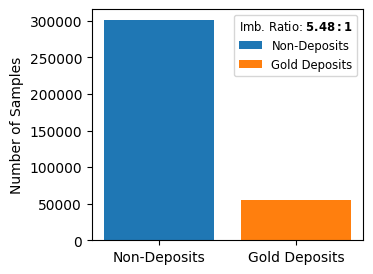

In [20]:
num_pos = np.sum(y_valid == 1)
num_neg = np.sum(y_valid == 0)

# Calculate imbalance ratio
imb_ratio = np.sum(y_valid == 0) / np.sum(y_valid == 1)

fig, ax = plt.subplots(figsize=(3.5, 3))
ax.bar(0, num_neg, label='Non-Deposits')
ax.bar(1, num_pos, label='Gold Deposits')

# Format imbalance ratio with bold text
title_text = f"Imb. Ratio: " + r"$\mathbf{" + f"{imb_ratio:.2f}:1" + r"}$"

# Define font properties
title_font = FontProperties(size='small')

# Add legend with formatted title
ax.legend(title=title_text, fontsize='small', title_fontproperties=title_font)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Non-Deposits', 'Gold Deposits'])
ax.set_ylabel('Number of Samples')

plt.savefig(f"{FIGS_DIR}/fig4.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

By this graph, we can see that the dataset is heavely imbalanced. This confirms the need for imbalance‐aware methods (e.g., scale_pos_weight, threshold tuning, or cost‐sensitive metrics like average precision).

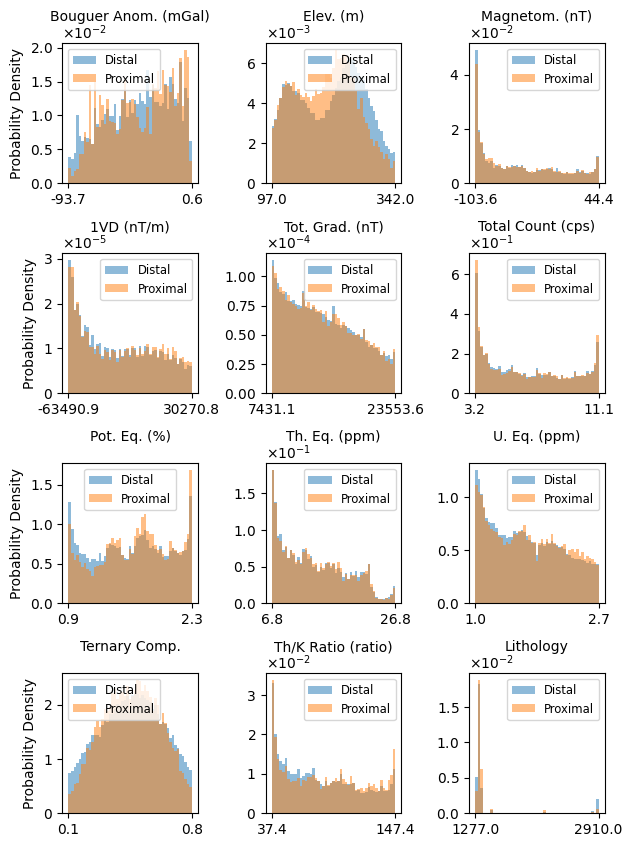

In [21]:
n_features = X_valid.shape[1]
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(7, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < n_features:
        row_idx = i // ncols
        col_idx = i % ncols

        feature_values = X_valid[:, i]

        min_val = np.nanpercentile(feature_values, 5)
        max_val = np.nanpercentile(feature_values, 95)
        if min_val == max_val:
            min_val, max_val = np.nanmin(feature_values), np.nanmax(feature_values)
        bins = np.linspace(min_val, max_val, 50)

        # Plot overlapping histograms for Distal (y=0) and Proximal (y=1)
        ax.hist(feature_values[y_valid == 0],
                bins=bins,
                density=True,
                alpha=0.5,
                label='Distal')
        ax.hist(feature_values[y_valid == 1],
                bins=bins,
                density=True,
                alpha=0.5,
                label='Proximal')

        disp_name = sorted_layer_names[i]
        units     = sorted_layer_units[i]

        if disp_name == "Ternary Comp." or disp_name == "Lithology":
            ax.set_title(f"{disp_name}", x=0.5, y=1.1, fontsize=10)
        else:
            ax.set_title(f"{disp_name} ({units})", x=0.5, y=1.1, fontsize=10)

        # Y-axis label only on the leftmost subplots
        if col_idx == 0:
            ax.set_ylabel('Probability Density')

        # Force x-axis to have exactly two ticks: min & max
        ax.set_xticks([min_val, max_val])
        ax.set_xticklabels([f"{min_val:.1f}", f"{max_val:.1f}"])

        # Set y-axis to scientific notation
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))  # Always use scientific notation
        ax.yaxis.set_major_formatter(formatter)

        # Adjust tick label size
        ax.tick_params(axis='y', labelsize=10)

        ax.legend(fontsize='small')
    else:
        ax.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig(f"{FIGS_DIR}/fig5.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

Based on the distributions of the layers, we can do the following transformations forll the feature engineering:

Categorical(Lithology): One-Hot-Encoder;
Layers with strictly positive and heavily skewed(Th/K Ratio, Total Count, U. Eq., Pot. Eq., Tot. Grad.): Log Transformations;
Layers with extreme outliers exist or negative values exist (1VD, Magnetom., Bouguer Anom.): Robust Scaler;
Tenary Comp.: unscaled or standard scaler.

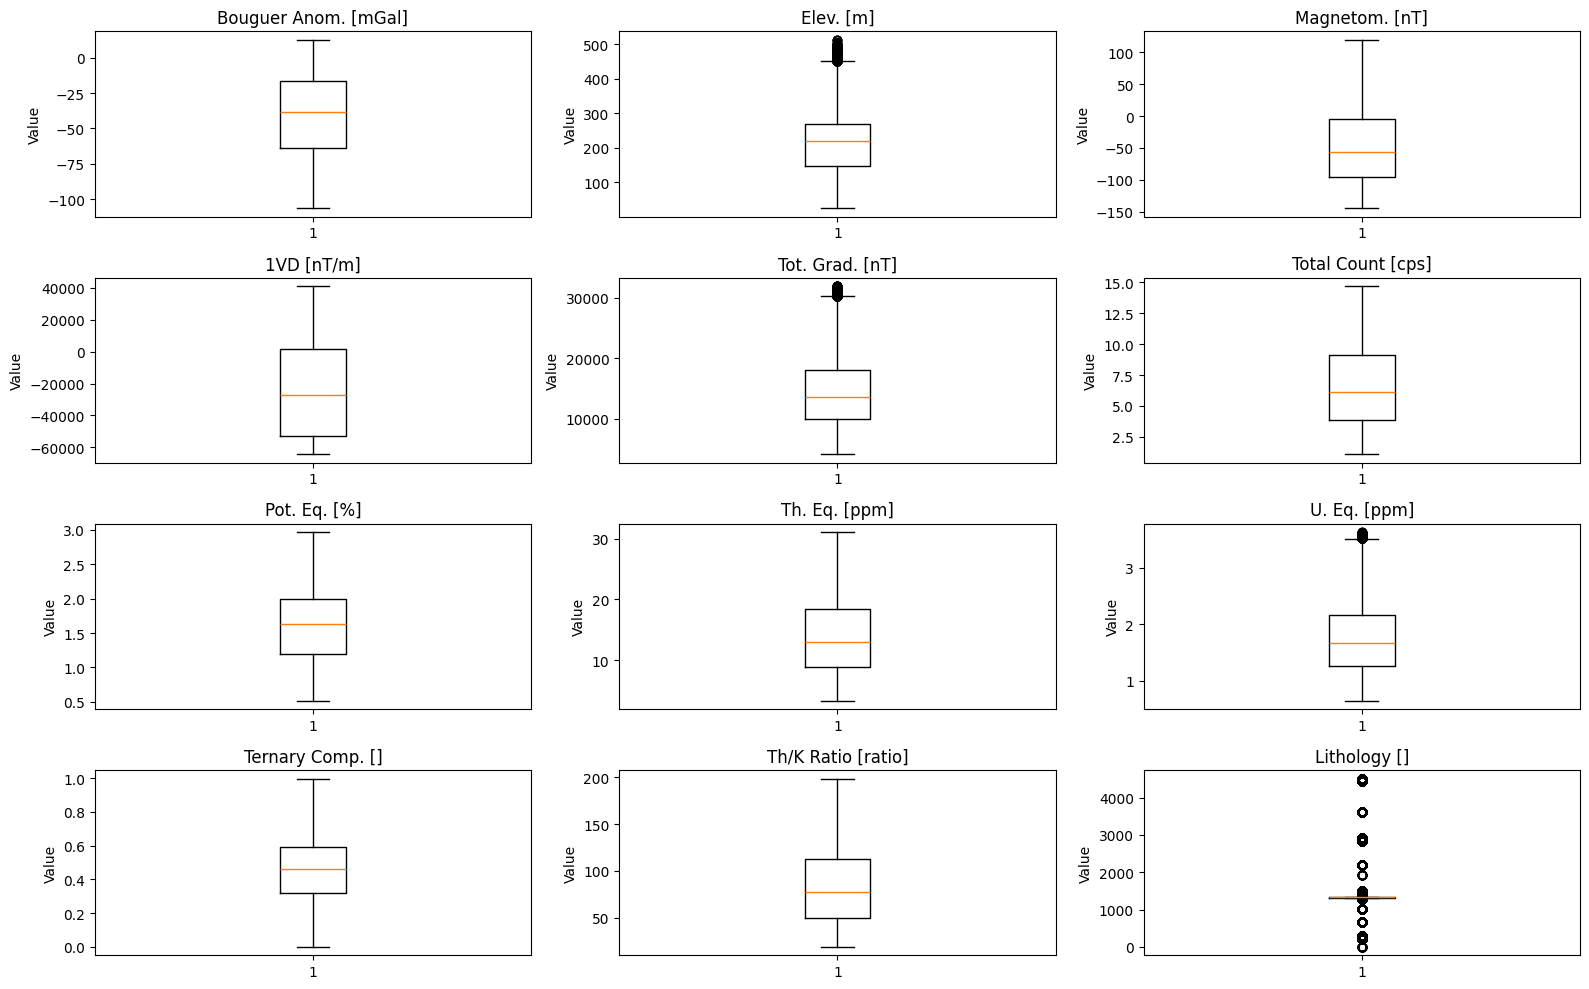

In [22]:
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 10))
axes = axes.ravel()

for i in range(n_layers):
    ax = axes[i]
    layer_values = X_valid[:, i]
    disp_name    = sorted_layer_names[i]
    units        = sorted_layer_units[i]

    ax.boxplot(layer_values, vert=True, whis=1.5)
    ax.set_title(f"{disp_name} [{units}]")
    ax.set_ylabel("Value")

for j in range(i+1, nrows*ncols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [23]:
def iqr_outlier_fraction(values, iqr_factor=1.5):
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lb = Q1 - iqr_factor * IQR
    ub = Q3 + iqr_factor * IQR
    outliers = (values < lb) | (values > ub)
    return np.mean(outliers), (lb, ub)

print("\nOutlier Fractions (1.5 * IQR Method) per sorted layer:")
for i in range(n_layers):
    disp_name = sorted_layer_names[i]
    layer_values = X_valid[:, i]
    frac, (lb, ub) = iqr_outlier_fraction(layer_values, 1.5)
    print(f"  {disp_name:25s} | {frac:.2%} outliers | [LB={lb:.2f}, UB={ub:.2f}]")


Outlier Fractions (1.5 * IQR Method) per sorted layer:
  Bouguer Anom.             | 0.00% outliers | [LB=-134.12, UB=53.78]
  Elev.                     | 0.18% outliers | [LB=-33.50, UB=450.50]
  Magnetom.                 | 0.00% outliers | [LB=-229.11, UB=128.91]
  1VD                       | 0.00% outliers | [LB=-134535.00, UB=83553.85]
  Tot. Grad.                | 0.90% outliers | [LB=-2345.96, UB=30287.54]
  Total Count               | 0.00% outliers | [LB=-3.96, UB=17.00]
  Pot. Eq.                  | 0.00% outliers | [LB=0.01, UB=3.19]
  Th. Eq.                   | 0.00% outliers | [LB=-5.73, UB=33.05]
  U. Eq.                    | 0.26% outliers | [LB=-0.11, UB=3.52]
  Ternary Comp.             | 0.00% outliers | [LB=-0.09, UB=1.00]
  Th/K Ratio                | 0.00% outliers | [LB=-44.80, UB=208.00]
  Lithology                 | 42.73% outliers | [LB=1293.50, UB=1353.50]


Since, there aren't so many outliers and the ones that exist are not related to human error, there is no need to treat outliers. Also, some outliers may be geologically meaningful.

In [24]:
print("\nPoint-Biserial Correlation with Target (Gold Occurrence):")
for i in range(n_layers):
    disp_name = sorted_layer_names[i]
    corr, p_val = pointbiserialr(X_valid[:, i], y_valid)
    print(f"  {disp_name:25s} -> r={corr:.3f}, p={p_val:.3e}")


Point-Biserial Correlation with Target (Gold Occurrence):
  Bouguer Anom.             -> r=0.050, p=1.995e-197
  Elev.                     -> r=-0.068, p=0.000e+00
  Magnetom.                 -> r=0.008, p=7.683e-07
  1VD                       -> r=0.021, p=4.418e-36
  Tot. Grad.                -> r=0.007, p=9.399e-06
  Total Count               -> r=0.001, p=7.242e-01
  Pot. Eq.                  -> r=0.047, p=1.393e-169
  Th. Eq.                   -> r=-0.020, p=2.903e-31
  U. Eq.                    -> r=0.014, p=7.444e-16
  Ternary Comp.             -> r=0.005, p=1.173e-03
  Th/K Ratio                -> r=0.031, p=2.652e-76
  Lithology                 -> r=-0.044, p=7.799e-155


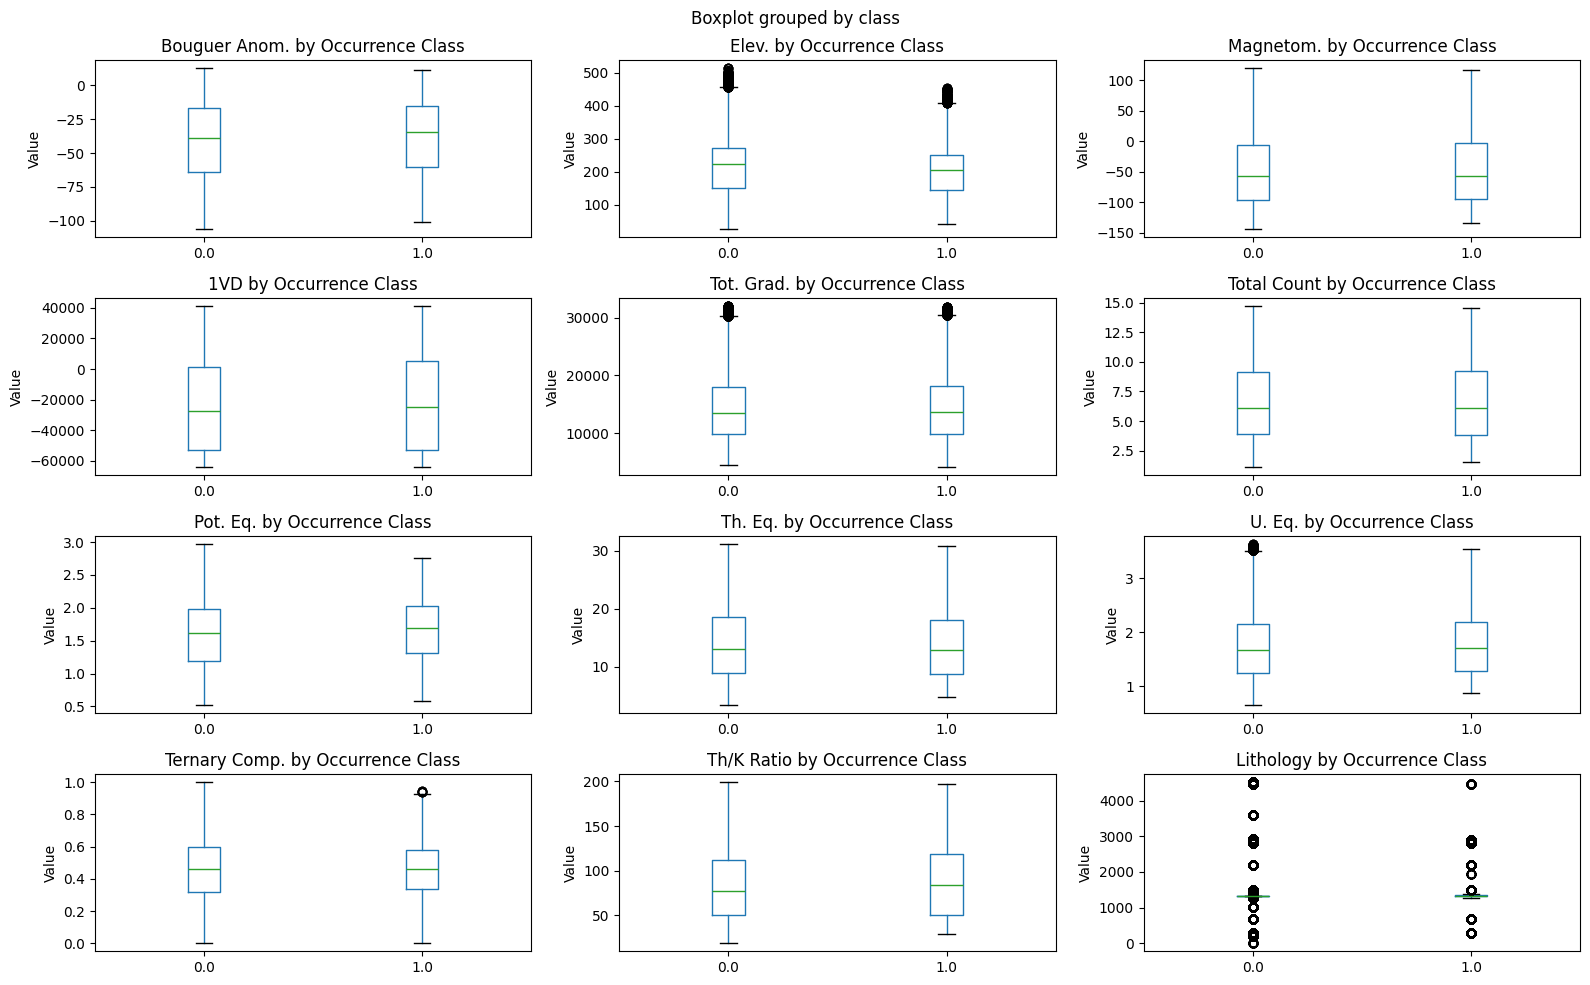

In [25]:
n_layers = len(sorted_layer_names)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,10))
axes = axes.flatten()

for i in range(n_layers):
    disp_name = sorted_layer_names[i]
    df_plot = pd.DataFrame({
        "value": X_valid[:, i],
        "class": y_valid
    })

    # Plot the boxplot
    df_plot.boxplot(by="class", column="value", grid=False, ax=axes[i])

    axes[i].set_title(f"{disp_name} by Occurrence Class")
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [26]:
lithology_idx_in_sorted = df_merged_sorted.loc[df_merged_sorted["display_name"]=="Lithology","plot_order"].iloc[0] - 1

print(f"\nLithology is at sorted index = {lithology_idx_in_sorted} in X_valid")


Lithology is at sorted index = 11 in X_valid


In [27]:
litho_values = X_valid[:, lithology_idx_in_sorted]
unique_lithos, counts = np.unique(litho_values, return_counts=True)

In [28]:
print("\nLithology frequencies in the valid data:")
for code, c in zip(unique_lithos, counts):
    print(f"  Code={code}: {c} pixels")


Lithology frequencies in the valid data:
  Code=0.0: 48 pixels
  Code=199.0: 1038 pixels
  Code=202.0: 532 pixels
  Code=276.0: 12034 pixels
  Code=290.0: 303 pixels
  Code=671.0: 1171 pixels
  Code=1006.0: 363 pixels
  Code=1277.0: 13365 pixels
  Code=1278.0: 1473 pixels
  Code=1279.0: 2381 pixels
  Code=1281.0: 32551 pixels
  Code=1289.0: 24 pixels
  Code=1290.0: 2460 pixels
  Code=1291.0: 61 pixels
  Code=1292.0: 290 pixels
  Code=1314.0: 3083 pixels
  Code=1316.0: 44123 pixels
  Code=1327.0: 39244 pixels
  Code=1331.0: 116631 pixels
  Code=1332.0: 505 pixels
  Code=1361.0: 25678 pixels
  Code=1362.0: 13161 pixels
  Code=1366.0: 2767 pixels
  Code=1369.0: 3022 pixels
  Code=1410.0: 125 pixels
  Code=1420.0: 890 pixels
  Code=1507.0: 5385 pixels
  Code=1936.0: 29 pixels
  Code=2191.0: 2776 pixels
  Code=2826.0: 2776 pixels
  Code=2910.0: 19579 pixels
  Code=2912.0: 3517 pixels
  Code=3605.0: 3341 pixels
  Code=4456.0: 455 pixels
  Code=4511.0: 174 pixels
  Code=4515.0: 154 pixels


In [29]:
# Cross-check with gold presence
lith_gold_counts = []
for lith_code in unique_lithos:
    mask = (litho_values == lith_code)
    gold_in_lith = np.sum(y_valid[mask] == 1)
    lith_gold_counts.append((lith_code, gold_in_lith))

# Sort descending by occurrences
lith_gold_counts.sort(key=lambda x: x[1], reverse=True)
top10 = lith_gold_counts[:10]
top10_codes = [x[0] for x in top10]
top10_occ   = [x[1] for x in top10]

In [30]:
top10_codes

[np.float32(1331.0),
 np.float32(1316.0),
 np.float32(1362.0),
 np.float32(1361.0),
 np.float32(1327.0),
 np.float32(1281.0),
 np.float32(1277.0),
 np.float32(1507.0),
 np.float32(2910.0),
 np.float32(2191.0)]

In [31]:
total_gold = sum(top10_occ)
top10_pct = [occ / total_gold * 100 for occ in top10_occ]

In [32]:
litho_data = pd.read_excel("/content/drive/MyDrive/OrePredictionProject/data/vector_data/lithology_spreadsheet.xlsx")

In [33]:
litho_data.head()

,fid,COD_UNI_ES,SIGLA_UNID,SIGLAS_ANT,NOME_UNIDA,HIERARQUIA,IDADE_MAX,ERRO_MAX,EON_IDAD_M,ERA_MAXIMA,...,ERRO_PRESS,TIPO_BARIC,TRAJETORIA,LITOTIPO1,LITOTIPO2,CLASSE_ROC,CLASSE_R_1,BB_SUBCLAS,BB_SUBCL_1,fid_2
0,1,1292,PP3_delta_inc,PP3_delta_sc,Gabro Serra Comprida,Corpo,1900.0,0,Proterozóico,Paleoproterozóico,...,NaN,NaN,NaN,NaN,"Quartzo gabro, Gabro",NaN,Ígnea,NaN,Plutônica,1
1,2,1289,PP3_delta_inij,PP3_delta_ij,Quartzo - Monzogabro Igarapé Jenipapo,Corpo,1900.0,0,Proterozóico,Paleoproterozóico,...,NaN,NaN,NaN,Quartzo monzogabro,"Quartzo monzonito, Quartzo sienito, Gabro, Ton...",Ígnea,Ígnea,Plutônica,Plutônica,1
2,3,1936,PP3_delta_inj,PP3_delta_j,Gabro Jutaí,Corpo,1879.0,0,Proterozóico,Paleoproterozóico,...,NaN,NaN,NaN,NaN,Gabro,NaN,Ígnea,NaN,Plutônica,1
3,4,1291,PP3_delta_inr,PP3_delta_rn,Gabro Rio Novo,Corpo,1999.0,3,Proterozóico,Paleoproterozóico,...,NaN,NaN,NaN,Olivina gabro,"Quartzo monzodiorito, Quartzo monzogabro, Gabro",Ígnea,Ígnea,Plutônica,Plutônica,1
4,5,1332,PP3_gamma_mlp,PP3_gamma_pe,Granito Pepita,Corpo,1870.0,4,Proterozóico,Paleoproterozóico,...,NaN,NaN,NaN,NaN,Álcali-feldspato granito,NaN,Ígnea,NaN,Plutônica,1


In [34]:
litho_map = dict(zip(litho_data["COD_UNI_ES"], litho_data["NOME_UNIDA"]))

In [35]:
top10_names = []
for code in top10_codes:
    if code in litho_map:
        top10_names.append(litho_map[code])
    else:
        top10_names.append(f"Unknown (code={code})")

In [36]:
top10_names

['Parauari',
 'Creporizão',
 'Cuiú-Cuiú',
 'Buiuçu',
 'Maloquinha',
 'Salustiano',
 'Aruri',
 'Depósitos aluvionares',
 'Capoeiras',
 'Sai Cinza']

In [37]:
top10_names = ['Alluv. dep.' if name == 'Depósitos aluvionares' else name for name in top10_names]

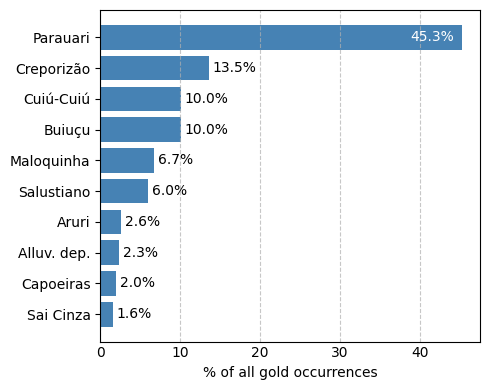

In [54]:
fig, ax = plt.subplots(figsize=(5, 4))
y_positions = np.arange(len(top10_names))
bars = ax.barh(y_positions, top10_pct, align='center', color='steelblue')

# draw vertical dashed lines at each major tick
ax.xaxis.set_ticks_position('both')
ax.xaxis.set_tick_params(which='major', length=0)  # hide tick‐marks
ax.grid(axis='x', linestyle='--', linewidth=0.8, alpha=0.7)

# labels & axis
ax.set_yticks(y_positions)
ax.set_yticklabels(top10_names)
ax.invert_yaxis()  # highest at top
ax.set_xlabel("% of all gold occurrences")

# annotate: first bar inside in white, others outside in black
for idx, (bar, pct) in enumerate(zip(bars, top10_pct)):
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    if idx == 0:
        # inside, white, centered
        x = width / 1.09
        color = 'white'
        ha = 'center'
    else:
        # just outside to the right, black, left-aligned
        x = width + 0.5
        color = 'black'
        ha = 'left'

    ax.text(
        x, y,
        f"{pct:.1f}%",
        ha=ha, va='center',
        color=color,
        fontsize=10
    )

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig6.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

The bar graph shows that the Parauari is the lithology with most gold occurences, followed by Creporizão, Buiuçu, Cuiú-Cuiú, Maloquinha and Salustino, and other lithologies appear with less occurences (Aruri, Alluv. deposits, Capoeiras and Sai Cinza).

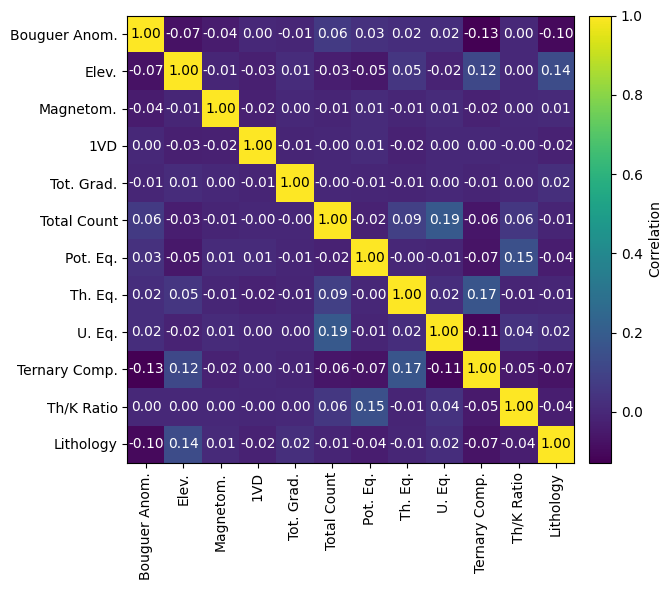

In [39]:
df_features = pd.DataFrame(X_valid, columns=sorted_layer_names)
corr_matrix = df_features.corr()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix, cmap='viridis', interpolation='none')
cbar = fig.colorbar(cax, ax=ax, label='Correlation', pad=0.02)

# set ticks
ax.set_xticks(np.arange(len(sorted_layer_names)))
ax.set_xticklabels(sorted_layer_names, rotation=90)
ax.set_yticks(np.arange(len(sorted_layer_names)))
ax.set_yticklabels(sorted_layer_names)

# annotate each cell
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        val = corr_matrix.iat[i, j]
        ax.text(j, i, f"{val:.2f}",
                ha='center', va='center',
                color='black' if abs(val) > 0.5 else 'white')

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig7.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()

In [40]:
print(corr_matrix)

               Bouguer Anom.     Elev.  Magnetom.       1VD  Tot. Grad.  \
Bouguer Anom.       1.000000 -0.071234  -0.040172  0.004081   -0.007819   
Elev.              -0.071234  1.000000  -0.005633 -0.028649    0.014598   
Magnetom.          -0.040172 -0.005633   1.000000 -0.023731    0.001780   
1VD                 0.004081 -0.028649  -0.023731  1.000000   -0.011390   
Tot. Grad.         -0.007819  0.014598   0.001780 -0.011390    1.000000   
Total Count         0.063310 -0.033711  -0.012192 -0.001069   -0.004069   
Pot. Eq.            0.031027 -0.052924   0.009298  0.013270   -0.007526   
Th. Eq.             0.020746  0.051829  -0.007446 -0.018215   -0.012714   
U. Eq.              0.020546 -0.017323   0.009855  0.001618    0.000835   
Ternary Comp.      -0.127615  0.115730  -0.017674  0.000468   -0.010172   
Th/K Ratio          0.004158  0.004033   0.000773 -0.000495    0.001078   
Lithology          -0.099959  0.135790   0.005970 -0.019822    0.024798   

               Total Cou

The matrix shows that the biggest correlations are: Total Count x U. Eq., Pot. Eq. x Th/K Ratio, Tenary x Th. Eq. and Tenary x Elev., but none of these correlations are really strong.